In [1]:
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
players_info_list = utils.get_dataframes_csv_file('../data/players_infos')
players_stats_list = utils.get_dataframes_csv_file('../data/players_stats')

In [3]:
schedule_df_list = utils.get_dataframes_csv_file('../data/schedules' )
standing_df_list = utils.get_dataframes_csv_file('../data/standings')
team_stats_df_list = utils.get_dataframes_csv_file('../data/teams_stats')

In [4]:
# Dictionnaire des abréviation des noms d'equipes NBA
nba_teams = {
    'Phoenix Suns': 'PHX',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Golden State Warriors': 'GSW',
    'Dallas Mavericks': 'DAL',
    'Boston Celtics': 'BOS',
    'Milwaukee Bucks': 'MIL',
    'Philadelphia 76ers': 'PHI',
    'Utah Jazz': 'UTA',
    'Toronto Raptors': 'TOR',
    'Denver Nuggets': 'DEN',
    'Minnesota Timberwolves': 'MIN',
    'Chicago Bulls': 'CHI',
    'Brooklyn Nets': 'BRK',  # 'New Jersey Nets' anciennement 'NJN'
    'Cleveland Cavaliers': 'CLE',
    'Atlanta Hawks': 'ATL',
    'Charlotte Hornets': 'CHA',  # 'Charlotte Bobcats' anciennement
    'LA Clippers': 'LAC',
    'New York Knicks': 'NYK',
    'New Orleans Pelicans': 'NOP',  # 'New Orleans Hornets' anciennement
    'Washington Wizards': 'WAS',
    'San Antonio Spurs': 'SAS',
    'Los Angeles Lakers': 'LAL',
    'Sacramento Kings': 'SAC',
    'Portland Trail Blazers': 'POR',
    'Indiana Pacers': 'IND',
    'Oklahoma City Thunder': 'OKC',  # 'Seattle SuperSonics' anciennement 'SEA'
    'Detroit Pistons': 'DET',
    'Orlando Magic': 'ORL',
    'Houston Rockets': 'HOU',
    'Seattle SuperSonics': 'SEA',  # Anciennement avant de devenir 'OKC'
    'New Jersey Nets': 'NJN',  # Anciennement avant de devenir 'BRK'
    'Charlotte Bobcats': 'CHA',  # Anciennement avant de redevenir 'CHA'
    'New Orleans Hornets': 'NOP',  # Anciennement avant de devenir 'NOP'
    'Vancouver Grizzlies': 'VAN',  # Anciennement avant de devenir 'MEM'
    'Kansas City Kings': 'KCK',  # Anciennement avant de devenir 'SAC'
    'San Diego Clippers': 'SDC',  # Anciennement avant de devenir 'LAC'
}
# Inverser le dictionnaire pour mapper les abréviations aux noms complets
abbrev_to_fullname = {v: k for k, v in nba_teams.items()}

In [5]:
teams_dict = {
    'New Orleans Pelicans': [' New Orleans '],
    'Phoenix Suns': [' Phoenix '],
    'Milwaukee Bucks': [' Milwaukee', 'Milwaukee '],
    'Charlotte Bobcats': [' Charlotte '],
    'NO/Oklahoma City Hornets': [' NO/Oklahoma City\r\n ', ' NO/Oklahoma City '],
    'Miami Heat': ['Miami ', ' Miami'],
    'New York Knicks': [' New York', 'New York ', ' New York '],
    'Detroit Pistons': [' Detroit', 'Detroit '],
    'Portland Trail Blazers': ['Portland ', ' Portland '],
    'Utah Jazz': [' Utah', 'Utah '],
    'Memphis Grizzlies': [' Memphis '],
    'Brooklyn Nets': [' Brooklyn', 'Brooklyn ', ' Brooklyn '],
    'Charlotte Hornets': [' Charlotte'],
    'Sacramento Kings': [' Sacramento', 'Sacramento '],
    'Toronto Raptors': [' Toronto ', 'Toronto '],
    'Denver Nuggets': ['Denver ', ' Denver'],
    'Minnesota Timberwolves': [' Minnesota ', 'Minnesota ', ' Minnesota'],
    'Golden State Warriors': ['Golden State ', ' Golden State '],
    'Orlando Magic': [' Orlando ', 'Orlando '],
    'Washington Wizards': ['Washington ', ' Washington', ' Washington'],
    'Cleveland Cavaliers': [' Cleveland ', 'Cleveland '],
    'New Orleans Hornets': [' NO/Oklahoma City\r\n ', ' NO/Oklahoma City ', ' NO/Oklahoma City\r\n '],
    'Los Angeles Lakers': [' Los Angeles ', 'Los Angeles ', 'LA ', ' LA '],
    'Dallas Mavericks': [' Dallas', ' Dallas '],
    'New Jersey Nets': [' New Jersey ', 'New Jersey '],
    'Seattle SuperSonics': ['Seattle '],
    'San Antonio Spurs': [' San Antonio ', ' San Antonio', 'San Antonio ', 'San Antonio '],
    'Houston Rockets': [' Houston', ' Houston ', 'Houston '],
    'Boston Celtics': [' Boston ', ' Boston', 'Boston '],
    'LA Clippers': [' LA '],
    'Indiana Pacers': ['Indiana ', ' Indiana ', ' Indiana'],
    'Chicago Bulls': ['Chicago ', ' Chicago ', ' Chicago'],
    'Atlanta Hawks': ['Atlanta ', ' Atlanta', ' Atlanta '],
    'Philadelphia 76ers': ['Philadelphia ', ' Philadelphia ', ' Philadelphia', ' Philadelphia '],
    'Oklahoma City Thunder': [' Oklahoma City ', ' Oklahoma City', ' Oklahoma City '],
}

# Praitrement et Préparation des données 

In [6]:
# Fonction pour extraire l'année de la saison à partir du titre
def get_season_year(title):
    if 'Players Information' in title or 'Regular_Season Players Statistic' in title:
        year_part = title.split(' ')[1]
    elif 'Standings Regular Season' in title or 'Team Regular Season Stats' in title:
        year_part = title.split(' ')[-1]
    elif 'Regular-Season-NBA-Schedule' in title:
        return int(title.split('-')[-6])
    else:
        return None

    if '-' in year_part:
        start_year = int(year_part.split('-')[0])
        return start_year
    return None

# Fonction pour vérifier si c'est une saison régulière
def is_regular_season(title):
    return 'Regular Season' in title or 'Regular_Season' or 'Regular-Season' in title

# Fonction pour filtrer les saisons avant 1980-81 et la saison 2023-24
def filter_season(title):
    season_year = get_season_year(title)
    if season_year is None:
        return False
    return 2002 <= season_year < 2023


In [7]:
# Fonction pour remplacer les noms des adversaires
def replace_opponent_names(df, teams_dict):
    for team, variations in teams_dict.items():
        for variation in variations:
            df['OPPONENT'] = df['OPPONENT'].str.replace(variation, team, regex=False)
    return df

# Appliquer la fonction à chaque dataframe de schedule_df_list
schedule_df_list = [replace_opponent_names(df, teams_dict) for df in schedule_df_list]

In [8]:
# Ajouter une colonne avec les noms complets des équipes 
for df in players_stats_list:
    df['Team Name'] = df['Team'].map(abbrev_to_fullname)
    df['Season'] = df['Title'].apply(get_season_year)

# Ajouter la colonne 'Season' dans les dataframes des équipes
for df in standing_df_list:
    df['Season'] = df['Title'].apply(get_season_year)
for df in team_stats_df_list:
    df['Season'] = df['Title'].apply(get_season_year)

In [9]:
players_info_list = [df for df in players_info_list if filter_season(df['Title'].iloc[0])]
players_stats_list = [df for df in players_stats_list if filter_season(df['Title'].iloc[0]) and is_regular_season(df['Title'].iloc[0])]
schedule_df_list = [df for df in schedule_df_list if filter_season(df['Title'].iloc[0]) and is_regular_season(df['Title'].iloc[0])]
standing_df_list = [df for df in standing_df_list if filter_season(df['Title'].iloc[0]) and is_regular_season(df['Title'].iloc[0])]
team_stats_df_list = [df for df in team_stats_df_list if filter_season(df['Title'].iloc[0]) and is_regular_season(df['Title'].iloc[0])]

In [10]:
# Calculating per minute stats for each DataFrame in players_stats_list
players_stats_list_per_min = []
for df in players_stats_list:
    df_per_min = df.copy()
    stats_columns = ['PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
    df_per_min[stats_columns + ['MIN']] = df_per_min[stats_columns + ['MIN']].apply(pd.to_numeric)
    for column in stats_columns:
        df_per_min[column] = df_per_min[column] / df_per_min['MIN']
    players_stats_list_per_min.append(df_per_min)

In [11]:
# Calculating per home+away games stats for each DataFrame in standing_df_list
standing_df_list_per_game = []
for df in standing_df_list:
    df_per_game = df.copy()
    game_columns = ['W', 'L', 'GB', 'HOME-W', 'HOME-L', 'AWAY-W', 'AWAY-L', 'DIV-W', 'DIV-L', 'CONF-W', 'CONF-L']
    df_per_game[game_columns] = df_per_game[game_columns].apply(pd.to_numeric)
    total_games = df_per_game['HOME-W'] + df_per_game['AWAY-W'] + df_per_game['HOME-L'] + df_per_game['AWAY-L']
    for column in game_columns:
        df_per_game[column] = df_per_game[column] / total_games
    standing_df_list_per_game.append(df_per_game)

In [12]:
# Calculating per game stats for each DataFrame in team_stats_df_list
team_stats_df_list_per_game = []
for df in team_stats_df_list:
    df_per_game = df.copy()
    team_stats_columns = ['PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OR', 'DR', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF']
    df_per_game[team_stats_columns + ['GP']] = df_per_game[team_stats_columns + ['GP']].apply(pd.to_numeric)
    for column in team_stats_columns:
        df_per_game[column] = df_per_game[column] / df_per_game['GP']
    team_stats_df_list_per_game.append(df_per_game)

In [13]:
# Replacing original dataframes with the new calculated dataframes in their respective lists
players_stats_list = players_stats_list_per_min
standing_df_list = standing_df_list_per_game
team_stats_df_list = team_stats_df_list_per_game

In [14]:
# Fusionner les dataframes de joueurs basés sur 'Player' et 'GP'
players_stats_combined = pd.concat(players_stats_list)
players_info_combined = pd.concat(players_info_list)
merged_players = players_stats_combined.merge(players_info_combined, on=['Player', 'GP'], how='inner')

In [15]:
# Fusionner les dataframes des équipes basés sur 'Team Name' et 'Season'
standing_combined = pd.concat(standing_df_list)
team_stats_combined = pd.concat(team_stats_df_list)
merged_teams = standing_combined.merge(team_stats_combined, on=['Team Name', 'Season'], how='inner')

In [16]:
# Ajouter les informations des matchs (schedules) sous forme de liste dans le dataframe fusionné des équipes
def get_schedule_list(team, season, schedule_df_list):
    schedules = []
    team_slug = team.replace(' ', '-')
    for df in schedule_df_list:
        if team_slug in df['Title'].iloc[0] and str(season) in df['Title'].iloc[0]:
            schedules.extend(df.to_dict(orient='records'))
    return schedules

merged_teams['Schedule'] = merged_teams.apply(lambda row: get_schedule_list(row['Team Name'], row['Season'], schedule_df_list), axis=1)

In [17]:
# Grouper les joueurs par 'Team Name' et 'Season'
grouped_players = merged_players.groupby(['Team Name', 'Season']).apply(lambda x: x.to_dict(orient='records')).reset_index()
grouped_players.columns = ['Team Name', 'Season', 'Players']

C:\Users\NeilB\AppData\Local\Temp\ipykernel_58160\2069172418.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_players = merged_players.groupby(['Team Name', 'Season']).apply(lambda x: x.to_dict(orient='records')).reset_index()


In [18]:
# Fusionner les dataframes des équipes avec les joueurs
final_df = merged_teams.merge(grouped_players, on=['Team Name', 'Season'], how='left')

In [19]:
len(final_df)

611

In [20]:
final_df.columns

Index(['Rank', 'Team Name', 'W', 'L', 'PCT', 'GB', 'PPG', 'OPP PPG', 'DIFF',
       'STRK', 'Title_x', 'HOME-W', 'HOME-L', 'AWAY-W', 'AWAY-L', 'DIV-W',
       'DIV-L', 'CONF-W', 'CONF-L', 'Last10-W', 'Last10-L', 'Season', 'GP',
       'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
       'OR', 'DR', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'Title_y',
       'Schedule', 'Players'],
      dtype='object')

In [28]:
# Créer les colonnes pour les stats de chaque équipe et de l'adversaire
match_data = []
existing_matches = set()
for index, row in final_df.iterrows():
    team1_name = row['Team Name']
    season = row['Season']
    team1_stats = row.drop(['Team Name', 'Season', 'Players', 'Schedule']).to_dict()
    team1_players = row['Players']
    for match in row['Schedule']:
        team2_name = match['OPPONENT']
        match_date = match['DATE']
        match_key = tuple(sorted([team1_name, team2_name]) + [match_date, season])
        if match_key in existing_matches:
            continue
        existing_matches.add(match_key)
        # Trouver les stats de team2
        team2_stats = final_df[(final_df['Team Name'] == team2_name) & (final_df['Season'] == season)].drop(['Team Name', 'Season', 'Players', 'Schedule'], axis=1).to_dict(orient='records')
        if not team2_stats:
            continue
        team2_stats = team2_stats[0]
        match_info = {f'{k}_team1': v for k, v in team1_stats.items()}
        match_info.update({f'{k}_team2': v for k, v in team2_stats.items()})
        match_info['Team1'] = team1_name
        match_info['Team2'] = team2_name
        match_info['Season'] = season
        match_info['Date'] = match_date
        match_info['Home_Away'] = match['Home_Away']
        match_info['Result'] = match['WorL']  # Win or Lose
        match_info['Points_team1'] = match['PTS']
        match_info['Points_team2'] = match['PTSO']
        # Ajouter les stats des joueurs pour les deux équipes
        match_info['Players_team1'] = team1_players
        team2_players = final_df[(final_df['Team Name'] == team2_name) & (final_df['Season'] == season)]['Players'].values
        if len(team2_players) > 0:
            match_info['Players_team2'] = team2_players[0]
        else:
            match_info['Players_team2'] = []
        match_data.append(match_info)

In [29]:
match_df = pd.DataFrame(match_data)

In [30]:
len(match_df)

0

In [24]:
# Créer les labels (1 pour victoire, 0 pour défaite)
match_df['Label'] = match_df['Result'].apply(lambda x: 1 if x == 'W' else 0)

KeyError: 'Result'

In [ ]:
match_df.columns

Index(['W_team1', 'L_team1', 'PCT_team1', 'GB_team1', 'PPG_team1',
       'OPP PPG_team1', 'DIFF_team1', 'STRK_team1', 'Title_x_team1',
       'HOME-W_team1', 'HOME-L_team1', 'AWAY-W_team1', 'AWAY-L_team1',
       'DIV-W_team1', 'DIV-L_team1', 'CONF-W_team1', 'CONF-L_team1',
       'Last10-W_team1', 'Last10-L_team1', 'Rank_team1', 'GP_team1',
       'PTS_team1', 'FGM_team1', 'FGA_team1', 'FG%_team1', '3PM_team1',
       '3PA_team1', '3P%_team1', 'FTM_team1', 'FTA_team1', 'FT%_team1',
       'OR_team1', 'DR_team1', 'REB_team1', 'AST_team1', 'STL_team1',
       'BLK_team1', 'TO_team1', 'PF_team1', 'Title_y_team1', 'W_team2',
       'L_team2', 'PCT_team2', 'GB_team2', 'PPG_team2', 'OPP PPG_team2',
       'DIFF_team2', 'STRK_team2', 'Title_x_team2', 'HOME-W_team2',
       'HOME-L_team2', 'AWAY-W_team2', 'AWAY-L_team2', 'DIV-W_team2',
       'DIV-L_team2', 'CONF-W_team2', 'CONF-L_team2', 'Last10-W_team2',
       'Last10-L_team2', 'Rank_team2', 'GP_team2', 'PTS_team2', 'FGM_team2',
       'F

#### --

In [ ]:
# Fonction pour trier les joueurs par GP et prendre les 8 meilleurs
def get_top_players(players, top_n=8):
    if not isinstance(players, list):
        return []
    sorted_players = sorted(players, key=lambda x: x.get('GP', 0), reverse=True)
    return sorted_players[:top_n]

# Fonction pour développer les statistiques des joueurs en colonnes
def expand_player_stats(players, prefix, max_players):
    expanded_stats = {}
    for i in range(max_players):
        player_stats = {f"{prefix}_player_{i+1}_{k}": v for k, v in (players[i] if isinstance(players, list) and i < len(players) else {}).items()}
        expanded_stats.update(player_stats)
    return expanded_stats

# Nombre maximal de joueurs à prendre
max_players = 8

# Développer les statistiques des joueurs pour les deux équipes
expanded_player_stats_team1 = pd.DataFrame([expand_player_stats(get_top_players(row, max_players), 'team1', max_players) for row in match_df['Players_team1']])
expanded_player_stats_team2 = pd.DataFrame([expand_player_stats(get_top_players(row, max_players), 'team2', max_players) for row in match_df['Players_team2']])

# Conserver les anciennes colonnes tout en ajoutant les nouvelles colonnes
match_df_expanded = pd.concat([match_df, expanded_player_stats_team1, expanded_player_stats_team2], axis=1)

In [ ]:
match_df_expanded.columns

Index(['W_team1', 'L_team1', 'PCT_team1', 'GB_team1', 'PPG_team1',
       'OPP PPG_team1', 'DIFF_team1', 'STRK_team1', 'Title_x_team1',
       'HOME-W_team1',
       ...
       'team2_player_8_Team Name', 'team2_player_8_Season',
       'team2_player_8_Pos', 'team2_player_8_HT', 'team2_player_8_WT',
       'team2_player_8_Age', 'team2_player_8_Teams', 'team2_player_8_YOS',
       'team2_player_8_Nationality', 'team2_player_8_Title_y'],
      dtype='object', length=619)

#### Encodage des valeurs non numérique 

In [ ]:
def pos_encoding(pos):
    if pos == None:
        return 0
    if pos == 'C':
        return 1
    if pos == 'F':
        return 2
    if pos == 'FC':
        return 3
    if pos == 'G':
        return 4
    if pos == 'GF':
        return 5
    return 0
    
# Columns to encode
pos_columns = [col for col in match_df_expanded.columns if 'Pos' in col or 'pos' in col]

# Encode the position columns
for column in pos_columns:
    if column in match_df_expanded.columns:
        match_df_expanded[column] = match_df_expanded[column].map(pos_encoding)

In [ ]:
# Fonction pour transformer STRK
def transform_strk(value):
    if pd.isna(value):
        return 0
    if value.startswith('W'):
        return int(value[1:])
    elif value.startswith('L'):
        return -int(value[1:])
    else:
        return 0

# Appliquer la transformation sur la colonne STRK
match_df_expanded['STRK_team1'] = match_df['STRK_team1'].apply(transform_strk)
match_df_expanded['STRK_team2'] = match_df['STRK_team2'].apply(transform_strk)

In [ ]:
# Transformer la colonne Date en jours écoulés depuis le début de l'année de la saison et ajouter l'année
def convert_date_with_year(row):
    day, month = map(int, row['Date'].split('/'))
    date = int(row['Season']) * 10000 + int(month) * 100 + int(day)
    return date

match_df_expanded['Date'] = match_df_expanded.apply(convert_date_with_year, axis=1)

In [ ]:
# Transformer la colonne Home_Away en int : 1 pour H et 0 pour A
match_df_expanded['Home_Away'] = match_df_expanded['Home_Away'].apply(lambda x: 1 if x == 'H' else 0)

# Transformer la colonne Result en int : 1 pour W et 0 pour L
match_df_expanded['Result'] = match_df_expanded['Result'].apply(lambda x: 1 if x == 'W' else 0)

# Supprimer les colonnes Players_team1 et Players_team2
match_df_expanded.drop(columns=['Players_team1', 'Players_team2'], inplace=True)

# Supprimer toutes les colonnes où il y a Title ou title dans le nom de la colonne
match_df_expanded.drop(columns=[col for col in match_df_expanded.columns if 'title' in col.lower()], inplace=True)

In [ ]:
# Initialiser une liste pour stocker les noms de colonnes non numériques
non_numeric_columns = []

# Parcourir toutes les lignes et colonnes du DataFrame
for col in match_df_expanded.columns:
    for val in match_df_expanded[col]:
        if val == None:
            continue
        if not isinstance(val, (int, float, complex)):
            if col not in non_numeric_columns:
                non_numeric_columns.append(col)
            break  # Si une valeur non numérique est trouvée, on peut arrêter de vérifier cette colonne

# Afficher la liste des colonnes non numériques
print("Colonnes non numériques :", non_numeric_columns)

Colonnes non numériques : ['Team1', 'Team2', 'team1_player_1_Player', 'team1_player_1_Team', 'team1_player_1_Team Name', 'team1_player_1_Teams', 'team1_player_1_Nationality', 'team1_player_2_Player', 'team1_player_2_Team', 'team1_player_2_Team Name', 'team1_player_2_Teams', 'team1_player_2_Nationality', 'team1_player_3_Player', 'team1_player_3_Team', 'team1_player_3_Team Name', 'team1_player_3_Teams', 'team1_player_3_Nationality', 'team1_player_4_Player', 'team1_player_4_Team', 'team1_player_4_Team Name', 'team1_player_4_Teams', 'team1_player_4_Nationality', 'team1_player_5_Player', 'team1_player_5_Team', 'team1_player_5_Team Name', 'team1_player_5_Teams', 'team1_player_5_Nationality', 'team1_player_6_Player', 'team1_player_6_Team', 'team1_player_6_Team Name', 'team1_player_6_Teams', 'team1_player_6_Nationality', 'team1_player_7_Player', 'team1_player_7_Team', 'team1_player_7_Team Name', 'team1_player_7_Teams', 'team1_player_7_Nationality', 'team1_player_8_Player', 'team1_player_8_Team

In [ ]:
# Fonction pour vérifier si une valeur est numérique
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Parcourir toutes les colonnes et encoder les colonnes non numériques
label_encoders = {}

for column in non_numeric_columns:
    if column in match_df_expanded.columns:
        match_df_expanded[column].fillna('NaN_placeholder', inplace=True)
        
        if match_df_expanded[column].dtype == 'object' and match_df_expanded[column].apply(is_numeric).all():
            # Si toutes les valeurs sont numériques, les convertir en float
            match_df_expanded[column] = match_df_expanded[column].astype(float)
        elif match_df_expanded[column].dtype == 'object' and match_df_expanded[column].nunique() <= 10:
            # Utiliser OneHotEncoder si le nombre de valeurs uniques est faible
            enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded = enc.fit_transform(match_df_expanded[[column]])
            encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out([column]))
            match_df_expanded.drop(column, axis=1, inplace=True)
            match_df_expanded = pd.concat([match_df_expanded, encoded_df], axis=1)
        else:
            # Utiliser LabelEncoder sinon
            le = LabelEncoder()
            match_df_expanded[column] = le.fit_transform(match_df_expanded[column].astype(str))
            label_encoders[column] = le

C:\Users\Kadem\AppData\Local\Temp\ipykernel_64540\1918497342.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  match_df_expanded[column].fillna('NaN_placeholder', inplace=True)
C:\Users\Kadem\AppData\Local\Temp\ipykernel_64540\1918497342.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [ ]:
match_df_expanded = match_df_expanded.drop(['Result'], axis=1)

KeyError: "['Result'] not found in axis"

In [ ]:
len(match_df_expanded.columns)

580

In [ ]:
[col for col in match_df_expanded.columns]

['W_team1',
 'L_team1',
 'PCT_team1',
 'GB_team1',
 'PPG_team1',
 'OPP PPG_team1',
 'DIFF_team1',
 'STRK_team1',
 'HOME-W_team1',
 'HOME-L_team1',
 'AWAY-W_team1',
 'AWAY-L_team1',
 'DIV-W_team1',
 'DIV-L_team1',
 'CONF-W_team1',
 'CONF-L_team1',
 'Last10-W_team1',
 'Last10-L_team1',
 'Rank_team1',
 'GP_team1',
 'PTS_team1',
 'FGM_team1',
 'FGA_team1',
 'FG%_team1',
 '3PM_team1',
 '3PA_team1',
 '3P%_team1',
 'FTM_team1',
 'FTA_team1',
 'FT%_team1',
 'OR_team1',
 'DR_team1',
 'REB_team1',
 'AST_team1',
 'STL_team1',
 'BLK_team1',
 'TO_team1',
 'PF_team1',
 'W_team2',
 'L_team2',
 'PCT_team2',
 'GB_team2',
 'PPG_team2',
 'OPP PPG_team2',
 'DIFF_team2',
 'STRK_team2',
 'HOME-W_team2',
 'HOME-L_team2',
 'AWAY-W_team2',
 'AWAY-L_team2',
 'DIV-W_team2',
 'DIV-L_team2',
 'CONF-W_team2',
 'CONF-L_team2',
 'Last10-W_team2',
 'Last10-L_team2',
 'Rank_team2',
 'GP_team2',
 'PTS_team2',
 'FGM_team2',
 'FGA_team2',
 'FG%_team2',
 '3PM_team2',
 '3PA_team2',
 '3P%_team2',
 'FTM_team2',
 'FTA_team2',


In [ ]:
reducted_columns = match_df_expanded.columns

In [ ]:
match_df_reduced = match_df_expanded[reducted_columns]

In [ ]:
match_df_reduced.columns

Index(['W_team1', 'L_team1', 'PCT_team1', 'GB_team1', 'PPG_team1',
       'OPP PPG_team1', 'DIFF_team1', 'STRK_team1', 'HOME-W_team1',
       'HOME-L_team1',
       ...
       'team2_player_8_PF', 'team2_player_8_Team Name',
       'team2_player_8_Season', 'team2_player_8_Pos', 'team2_player_8_HT',
       'team2_player_8_WT', 'team2_player_8_Age', 'team2_player_8_Teams',
       'team2_player_8_YOS', 'team2_player_8_Nationality'],
      dtype='object', length=580)

In [ ]:
# Enregistrer match_df dans un fichier CSV
match_df_expanded.to_csv('../data/final_data_set.csv', index=False)

# Machine Learning : Prédiction des matchs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize

### Chargement des Features 

In [ ]:
match_df_expanded.columns 

Index(['W_team1', 'L_team1', 'PCT_team1', 'GB_team1', 'PPG_team1',
       'OPP PPG_team1', 'DIFF_team1', 'STRK_team1', 'HOME-W_team1',
       'HOME-L_team1',
       ...
       'team2_player_8_PF', 'team2_player_8_Team Name',
       'team2_player_8_Season', 'team2_player_8_Pos', 'team2_player_8_HT',
       'team2_player_8_WT', 'team2_player_8_Age', 'team2_player_8_Teams',
       'team2_player_8_YOS', 'team2_player_8_Nationality'],
      dtype='object', length=580)

In [ ]:
features_list = [col for col in match_df_expanded.columns if col != 'Label']
features, labels = match_df_reduced[features_list], match_df_reduced['Label']

# Binariser les étiquettes pour l'affichage des courbes ROC
labels_bin = label_binarize(labels, classes=np.unique(labels))

# Diviser les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Entrainement et évaluation des différents modèles

In [ ]:
import seaborn as sns

# Fonction pour afficher les métriques de classification
def evaluate_model(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    print('\nRapport de classification:')
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\nMatrice de confusion:')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for class_id in np.unique(labels):
        y_test_bin = label_binarize(y_test, classes=np.unique(labels))[:, class_id]
        y_score = model.predict_proba(X_test)[:, class_id]
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_id} (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Fonction pour tracer les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")
    
    plt.legend(loc="best")
    plt.show()


#### RandomForestClassifier

Best parameters for RandomForestClassifier: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 5, 'classifier__n_estimators': 100}

Rapport de classification:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1523
           1       0.68      0.58      0.63      1283

    accuracy                           0.68      2806
   macro avg       0.68      0.67      0.67      2806
weighted avg       0.68      0.68      0.68      2806


Matrice de confusion:
[[1169  354]
 [ 538  745]]


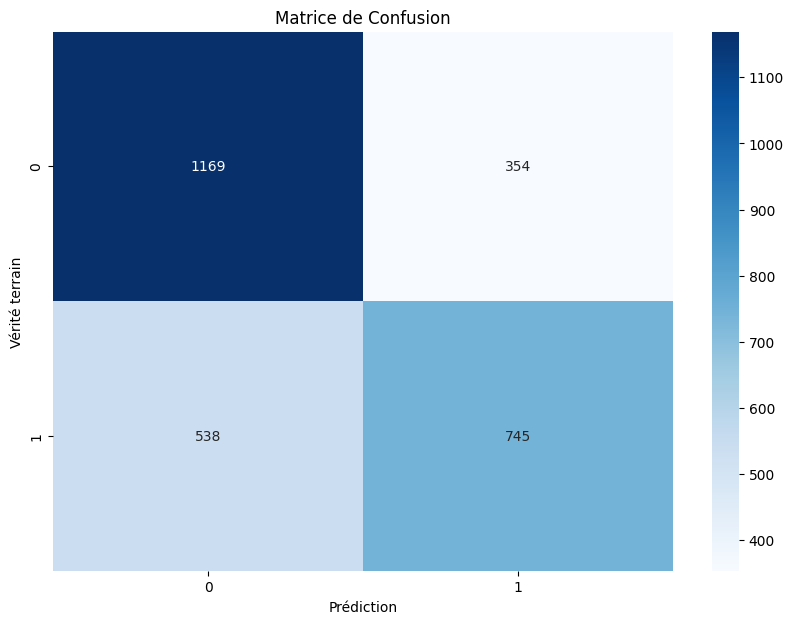

An error occurred during training RandomForestClassifier: index 1 is out of bounds for axis 1 with size 1


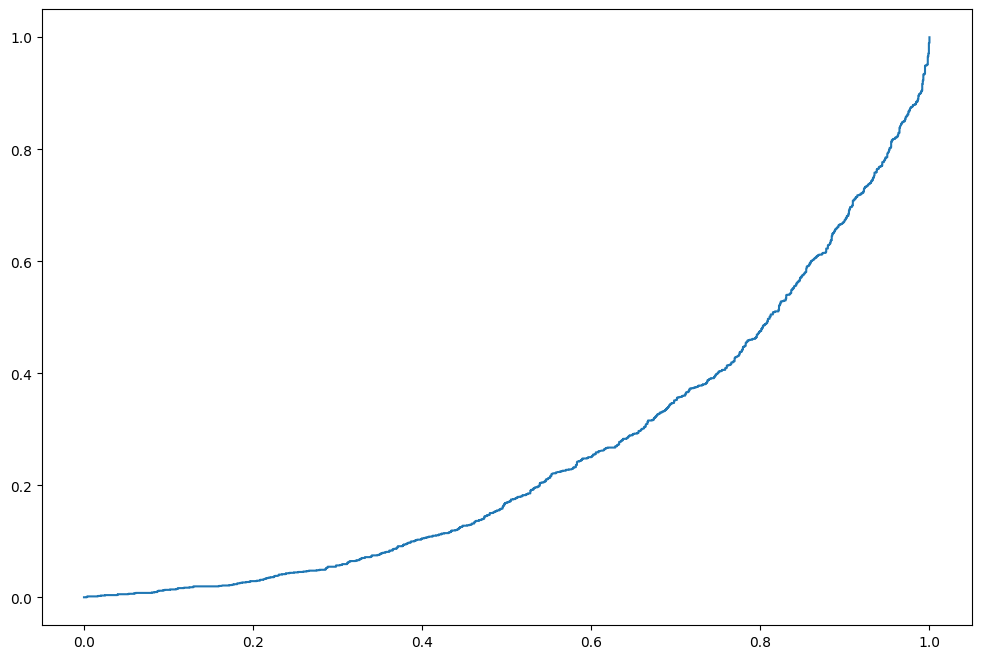

In [ ]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Paramètres pour RandomForestClassifier
param_grid_rf = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}

# Pipeline pour RandomForestClassifier
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearchCV pour RandomForestClassifier
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')

# Entraîner et évaluer RandomForestClassifier
try:
    grid_search_rf.fit(X_train, y_train)
    best_model_rf = grid_search_rf.best_estimator_
    print(f'Best parameters for RandomForestClassifier: {grid_search_rf.best_params_}')
    evaluate_model(best_model_rf, X_test, y_test, np.unique(labels))
    plot_learning_curve(best_model_rf, "Learning Curve for RandomForestClassifier", X_train, y_train, cv=5)
except Exception as e:
    print()


#### GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Paramètres pour GradientBoostingClassifier
param_grid_gb = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [100],
    'classifier__learning_rate': [0.01, 0.1]
}

# Pipeline pour GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# GridSearchCV pour GradientBoostingClassifier
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')

# Entraîner et évaluer GradientBoostingClassifier
try:
    grid_search_gb.fit(X_train, y_train)
    best_model_gb = grid_search_gb.best_estimator_
    print(f'Best parameters for GradientBoostingClassifier: {grid_search_gb.best_params_}')
    evaluate_model(best_model_gb, X_test, y_test, np.unique(labels))
    plot_learning_curve(best_model_gb, "Learning Curve for GradientBoostingClassifier", X_train, y_train, cv=5)
except Exception as e:
    print()


KeyboardInterrupt: 

#### SVC

In [ ]:
from sklearn.svm import SVC

# Paramètres pour SVC
param_grid_svc = {
    'classifier': [SVC(probability=True)],
    'classifier__C': [0.5, 5],
    'classifier__kernel': ['linear', 'rbf']
}

# Pipeline pour SVC
pipeline_svc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])

# GridSearchCV pour SVC
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')

# Entraîner et évaluer SVC
try:
    grid_search_svc.fit(X_train, y_train)
    best_model_svc = grid_search_svc.best_estimator_
    print(f'Best parameters for SVC: {grid_search_svc.best_params_}')
    evaluate_model(best_model_svc, X_test, y_test, np.unique(labels))
    plot_learning_curve(best_model_svc, "Learning Curve for SVC", X_train, y_train, cv=5)
except Exception as e:
    print()


#### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Paramètres pour KNeighborsClassifier
param_grid_knn = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [5, 7],
    'classifier__weights': ['uniform', 'distance']
}

# Pipeline pour KNeighborsClassifier
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# GridSearchCV pour KNeighborsClassifier
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')

# Entraîner et évaluer KNeighborsClassifier
try:
    grid_search_knn.fit(X_train, y_train)
    best_model_knn = grid_search_knn.best_estimator_
    print(f'Best parameters for KNeighborsClassifier: {grid_search_knn.best_params_}')
    evaluate_model(best_model_knn, X_test, y_test, np.unique(labels))
    plot_learning_curve(best_model_knn, "Learning Curve for KNeighborsClassifier", X_train, y_train, cv=5)
except Exception as e:
    print()


#### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Paramètres pour LogisticRegression
param_grid_lr = {
    'classifier': [LogisticRegression(max_iter=1000)],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']
}

# Pipeline pour LogisticRegression
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# GridSearchCV pour LogisticRegression
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')

# Entraîner et évaluer LogisticRegression
try:
    grid_search_lr.fit(X_train, y_train)
    best_model_lr = grid_search_lr.best_estimator_
    print(f'Best parameters for LogisticRegression: {grid_search_lr.best_params_}')
    evaluate_model(best_model_lr, X_test, y_test, np.unique(labels))
    plot_learning_curve(best_model_lr, "Learning Curve for LogisticRegression", X_train, y_train, cv=5)
except Exception as e:
    print()


##### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Paramètres pour AdaBoostClassifier
param_grid_ada = {
    'classifier': [AdaBoostClassifier()],
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1]
}

# Pipeline pour AdaBoostClassifier
pipeline_ada = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# GridSearchCV pour AdaBoostClassifier
grid_search_ada = GridSearchCV(pipeline_ada, param_grid_ada, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')

# Entraîner et évaluer AdaBoostClassifier
try:
    grid_search_ada.fit(X_train, y_train)
    best_model_ada = grid_search_ada.best_estimator_
    print(f'Best parameters for AdaBoostClassifier: {grid_search_ada.best_params_}')
    evaluate_model(best_model_ada, X_test, y_test, np.unique(labels))
    plot_learning_curve(best_model_ada, "Learning Curve for AdaBoostClassifier", X_train, y_train, cv=5)
except Exception as e:
    print()
